In [2]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

# IMPORTS
import numpy as np
import random
import itertools
import json
import os
# Machine Learning imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_model_optimization
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print("tensorflow version:", tf.__version__)
import keras
print("keras version:",keras.__version__)
import qkeras
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
print("qkeras version:",keras.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Display and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
# Data management
import psutil
import h5py
# Memory management
import gc
# Notifications
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from dotenv import load_dotenv
load_dotenv()
def send_email_notification(subject, content):
    sender_email = os.getenv('EMAIL_USER')
    receiver_email = "alexander.j.yue@gmail.com"
    password = os.getenv('EMAIL_PASS')

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    body = content
    message.attach(MIMEText(body, "plain"))

    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message.as_string())

# Memory monitoring functions
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

2024-08-05 10:14:43.428385: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 10:14:43.511808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 10:14:43.513028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 10:14:45.124191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version: 2.13.1
keras version: 2.13.1
qkeras version: 2.13.1


In [3]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

# Load the pixel cluster to transverse momentum dataset into the input_data and target_data
def load_combine_shuffle_data_optimized_hdf5():
    # Load the dataset from Kenny's computer
    with h5py.File('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [26]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

def load_dataset():
    # Load dataset into memory
    input_data, target_data = load_combine_shuffle_data_optimized_hdf5()
    # Format the dataset into a 20x13x21 tensor (time, y, x)
    input_data = input_data.reshape(input_data.shape[0],20,13,21)
    global_max = np.max(input_data)
    global_min = np.min(input_data)
    print(f"max: {global_max}, min: {global_min}")
    return input_data, target_data, global_min, global_max

def process_dataset(input_data, target_data, hyperparams, global_min, global_max):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    TRAIN_PT_THRESHOLD = hyperparams["TRAIN_PT_THRESHOLD"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    OUTPUT = hyperparams["OUTPUT"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]
    Y0_SCALING = hyperparams["Y0_SCALING"]

    # Split 80% of data into training data, 10% for validation data and 10% for testing data
    input_train_data, input_temp, target_train_data, target_temp = \
    train_test_split(input_data, target_data, test_size=0.2, random_state=42)
    del input_data
    del target_data
    gc.collect()
    input_validate_data, input_test_data, target_validate_data, target_test_data = \
    train_test_split(input_temp, target_temp, test_size=0.5, random_state=42)
    del input_temp
    del target_temp
    gc.collect()

    # Save all test data for displaying
    input_data_example = input_test_data
    target_data_example = target_test_data

    # Initiate the scalers on the training data 
    if INPUT_SCALING == "Standard":
        input_scaler = StandardScaler()
        input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    if Y0_SCALING == "Standard":
        y0_scaler = StandardScaler()
        y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))
    if INPUT_SCALING == "MinMax":
        input_scaler = MinMaxScaler()
        input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    if Y0_SCALING == "MinMax":
        y0_scaler = MinMaxScaler()
        y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))

    # Process the data into input shape and labels for training
    def process_data(input_data, target_data, pt_threshold):
        if input_data.shape[1:] == (20, 13, 21) and target_data.shape[1:] == (13, ):

            # Truncate down to first time slices
            input_data = input_data[:, :NUM_TIME_SLICES, :, :]

            # sum over the x axis to turn the input data into a 2D NUM_TIME_SLICES x 13 tensor (time, y)
            input_data = np.sum(input_data, axis=3)

            if OUTPUT == "SOFTMAX" or OUTPUT == "LINEAR":
                # Encode the target data into one_hot encoding
                one_hot = np.zeros((target_data.shape[0], 3))
                # Assign 1 for p_t > pt_threshold in GeV, for low p_t put 1 in slot 2 for negative and a 1 in slot 3 for positive
                one_hot[np.abs(target_data[:, 8]) >= pt_threshold, 0] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] > 0), 1] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] < 0), 2] = 1
                label_data = one_hot
            # elif OUTPUT == "ARGMAX": # DOES NOT WORK 
            #     label_data = np.argmax(one_hot, axis=1).astype(np.int64)
            #     print("one hot is ", one_hot)
            elif OUTPUT == "SINGLE":
            # Binary labels for 0th category
                label_data = (np.abs(target_data[:, 8]) >= pt_threshold).astype(np.int64)

            # Flatten the input data
            input_data = input_data.reshape(-1,NUM_TIME_SLICES*13)

            # Get the y_0 data
            y0_data = target_data[:,7].reshape(-1, 1)

            # Normalize the input data according to scaling method
            if INPUT_SCALING == "Standard" or INPUT_SCALING == "MinMax":
                input_data = input_scaler.transform(input_data)
            elif INPUT_SCALING == "Log":
                # Replace all values < 1 with 1 so they log to 0
                input_data = np.where(np.abs(input_data) < 1.0, 1.0, input_data)
                # Apply logarithmic scaling
                input_data = np.log(np.abs(input_data)) * np.sign(input_data)
                # Min-max normalization (global)
                global_log_min = np.log(np.abs(global_min)) * np.sign(global_min)
                global_log_max = np.log(np.abs(global_max)) * np.sign(global_max)
                input_data = (input_data) / global_log_max
                # Take square root of abs to better distribute it
                input_data = np.square(np.abs(input_data)) * np.sign(input_data)
            elif INPUT_SCALING == "Quantized":
                if (IO_BITS == 2):
                    bin_edges = [-np.inf, 400, 1600, 2400, np.inf]
                    bin_values = [-1.0, -0.5, 0.0, 0.5]
                else:
                    num_bins = 2**IO_BITS
                    bin_values = np.linspace(-1, 1 - 2/num_bins, num_bins)
                    
                    max_edge = 1600 + 400 * IO_BITS
                    non_inf_edges = np.linspace(0, max_edge, num_bins)[1:]
                    
                    bin_edges = np.concatenate([[-np.inf], non_inf_edges, [np.inf]])
                
                for i, edge in enumerate(bin_edges[1:]):
                    input_data[(input_data >= bin_edges[i]) & (input_data < edge)] = bin_values[i]
                input_data[input_data >= bin_edges[-1]] = bin_values[-1]
            elif INPUT_SCALING == "None":
                print("NO INPUT SCALING")
            else:
                raise ValueError(f"scaling input by {INPUT_SCALING} not supported yet")
                
            if Y0_SCALING == "Standard" or Y0_SCALING == "MinMax":
                y0_data = y0_scaler.transform(y0_data)
            elif Y0_SCALING == "Linear":
                y0_data = y0_data / 8
            else:
                raise ValueError(f"scaling y0 by {Y0_SCALING} not supported yet")

            
            # Combine with input data
            if (MODEL_TYPE == "DNN" or MODEL_TYPE == "AE"):
                # For DNN we concatenate in the y_0 data
                input_data_combined = np.hstack((input_data, y0_data))
            elif (MODEL_TYPE == "CNN"):
                # Reshape data into a matrix for the convolutions
                input_data = input_data.reshape(-1, NUM_TIME_SLICES, 13)
                # Package with the y_0 data to be added later
                input_data_combined = [input_data, y0_data]
            else: 
                raise ValueError(f"unsupported MODEL_TYPE {MODEL_TYPE}") 
            
            return input_data_combined, label_data
        else:
            raise ValueError("Wrong array shape!")

    # Apply data processing to our datasets
    input_train_data_combined, target_train_data_coded = process_data(input_train_data, target_train_data, TRAIN_PT_THRESHOLD)
    input_validate_data_combined, target_validate_data_coded = process_data(input_validate_data, target_validate_data, TRAIN_PT_THRESHOLD)
    input_test_data_combined, target_test_data_coded = process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD)

    # Save all test data for displaying
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "AE":
        input_data_combined_example = input_test_data_combined
        target_data_coded_example = target_test_data_coded
    elif MODEL_TYPE == "CNN":
        input_data_combined_example = np.hstack((input_test_data_combined[0].reshape(100, -1), input_test_data_combined[1]))
        target_data_coded_example = target_test_data_coded
    else:
        raise ValueError("Invalid model type")

    print_memory_usage()
    max_input_test = np.max(input_test_data_combined)
    min_input_test = np.min(input_test_data_combined)

    processed_dataset = {
        "input_train_data_combined": input_train_data_combined,
        "target_train_data_coded": target_train_data_coded,
        "input_validate_data_combined": input_validate_data_combined,
        "target_validate_data_coded": target_validate_data_coded,
        "input_test_data_combined": input_test_data_combined,
        "target_test_data_coded": target_test_data_coded,

        "input_data_example": input_data_example,
        "target_data_example": target_data_example,
        "input_data_combined_example": input_data_combined_example,
        "target_data_coded_example": target_data_coded_example,

        "max_input_test": max_input_test,
        "min_input_test": min_input_test,
    }

    return processed_dataset 

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [5]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

# Defining the model
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArgmaxLayer(Layer):
    def __init__(self, **kwargs):
        super(ArgmaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(tf.argmax(inputs, axis=-1), dtype=tf.int64)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(ArgmaxLayer, self).get_config()
        return config
    
def qDNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    DNN_LAYERS = hyperparams["DNN_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    OUTPUT = hyperparams["OUTPUT"]
    
    y_timed_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='y_timed_input')
    layer = y_timed_input
    
    for i, size in enumerate(DNN_LAYERS):
        layer = QDense(
            size, 
            kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
            name=f'dense{i+1}')(layer)
        layer = BatchNormalization()(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS))(layer)

    if OUTPUT == "SOFTMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), 
        name='dense_output')(layer)
        output = Activation("softmax", name='output_softmax')(output)
    elif OUTPUT == "ARGMAX":
        output = QDense(3, 
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
        output = ArgmaxLayer(name='output_argmax')(output)
        print(f"Argmax output dtype: {output.dtype}")
    elif OUTPUT == "LINEAR":
        output = QDense(3, 
       kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    elif OUTPUT == "SINGLE":
        output = QDense(1, 
       kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        name='dense_output')(layer)
    else:
        raise ValueError("Not a supported output type")
   
    model = Model(inputs=y_timed_input, outputs=output)

    if OUTPUT == "SOFTMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                      loss='categorical_crossentropy', 
                      metrics=[Precision()])
    elif OUTPUT == "ARGMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=[Precision()])
    elif OUTPUT == "LINEAR":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='mse', 
              metrics=[Precision()])
    elif OUTPUT == "SINGLE":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


def qCNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    CONV_LAYER_DEPTHS = hyperparams["CONV_LAYER_DEPTHS"]
    CONV_LAYER_KERNELS = hyperparams["CONV_LAYER_KERNELS"]
    CONV_LAYER_STRIDES = hyperparams["CONV_LAYER_STRIDES"]
    MAX_POOLING_SIZE = hyperparams["MAX_POOLING_SIZE"]
    FLATTENED_LAYERS = hyperparams["FLATTENED_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]

    y_profile_input = Input(shape=(NUM_TIME_SLICES, 13, 1), name='y_profile_input')  # Adjust the shape based on your input
    layer = y_profile_input

    # Convolutional layers
    for i in range(len(CONV_LAYER_DEPTHS)):
        layer = QConv2D(
        CONV_LAYER_DEPTHS[i],
        kernel_size=CONV_LAYER_KERNELS[i],
        strides=CONV_LAYER_STRIDES[i],
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        padding='same',
        use_bias=True,
        name=f'conv{i+1}'
        )(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
        layer = MaxPooling2D(pool_size=MAX_POOLING_SIZE, name=f'maxpool{i+1}')(layer)

    # Flatten the output to feed into a dense layer
    layer = Flatten(name='flattened')(layer)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    layer = Concatenate(name='concat')([layer, y0_input])

    # Post-flattening dense layers
    for i in range(len(FLATTENED_LAYERS)):
        layer = QDense(FLATTENED_LAYERS[i], kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'dense{i+1}')(layer)
        layer = QActivation(quantized_relu(10), name=f'relu{len(CONV_LAYER_DEPTHS)+i+1}')(layer)

    # Output layer (adjust based on your classification problem)
    output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
    output = Activation("softmax", name='output_softmax')(output)
    # layer = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
    #                bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name='output_dense')(layer)
    # output = Activation("sigmoid", name='output_sigmoid')(layer)

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy']) # loss='binary_crossentropy'

    return model

def mae(y_true, y_pred): # Mean absolute error
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def rmse(y_true, y_pred): # room mean squared error
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

def qAEmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    AU_ENCODER_LAYERS = hyperparams["AU_ENCODER_LAYERS"]
    AU_DECODER_LAYERS = hyperparams["AU_DECODER_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]


    y_timed_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='y_timed_input')
    layer = y_timed_input

    layer = Flatten(name='flatten_input')(layer)

    all_layer_specs = AU_ENCODER_LAYERS + AU_DECODER_LAYERS
    # Add encoder and decoder layers
    for i in range(len(all_layer_specs)):
        layer_specs = all_layer_specs[i]

        if isinstance(layer_specs, int):
            layer_name = f'dense{i+1}'
            if (i == len(AU_ENCODER_LAYERS) - 1):
                layer_name = 'latent_space'
            layer = QDense(layer_specs, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=layer_name)(layer)
            layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
            layer = BatchNormalization(name=f'batch_norm{i+1}')(layer)
        else:
            raise ValueError(f"Unsupported layer specification: {layer_specs}")
        
    # output layer
    layer = QDense(NUM_TIME_SLICES*13 + 1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
            bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name="output")(layer)
    layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'output_relu')(layer)
    layer = BatchNormalization(name=f'output_batch_norm')(layer)
    
    model = Model(inputs=y_timed_input, outputs=layer)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared]) 

    return model


# Pruning the model
def pruneFunction(layer, train_data_size, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]

    steps_per_epoch = train_data_size // BATCH_SIZE #input_train_data_combined.shape[0]
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch # prune after every epoch
        )
    }


    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        else:
            print(f"cannot prune layer {layer.name}")
            return layer

    else:
        print(f"cannot prune layer {layer.name}")
        return layer
    
def pruneFunctionWrapper(train_data_size, hyperparams):
    def wrapper(layer):
        return pruneFunction(layer, train_data_size, hyperparams)
    return wrapper
    

# Function to calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()[0]
            total_params += weights.size
            zero_params += np.sum(weights == 0)
    sparsity = zero_params / total_params
    return sparsity

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [6]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

def train_model(data, hyperparams):
    input_train_data_combined = data["input_train_data_combined"]
    target_train_data_coded = data["target_train_data_coded"]
    input_validate_data_combined = data["input_validate_data_combined"]
    target_validate_data_coded = data["target_validate_data_coded"]

    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    PATIENCE = hyperparams["PATIENCE"]
    EPOCHS = hyperparams["EPOCHS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    POST_PRUNE_EPOCHS = hyperparams["POST_PRUNE_EPOCHS"]
    

    
    # Define the model
    if (MODEL_TYPE == "DNN"):
        model = qDNNmodel(hyperparams)
    elif (MODEL_TYPE == "CNN"):
        model = qCNNmodel(hyperparams)
    elif (MODEL_TYPE == "AE"):
        model = qAEmodel(hyperparams)
    else:
        raise ValueError("Not a supported model type")

    model.summary()
    print_qmodel_summary(model)
    print(f"Initial Sparsity: {calculate_sparsity(model) * 100:.2f}%")

    train_metrics = {}

    # Train the model
    earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        history = model.fit(
            input_train_data_combined, target_train_data_coded,  # Training data and labels
            validation_data=(input_validate_data_combined, target_validate_data_coded),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    elif (MODEL_TYPE == "AE"):
        history = model.fit(
            input_train_data_combined, input_train_data_combined,  # Training data as input and the output
            validation_data=(input_validate_data_combined, input_validate_data_combined),  # Validation data
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[earlyStop_callback] # , tensorboard_callback
        )
    else:
        raise ValueError("Not a supported model type")

    # Save the val_loss
    train_metrics["val_loss"] = history.history['val_loss'][-1]

   # Prune the model
    model_pruned = keras.models.clone_model(model, clone_function=pruneFunctionWrapper(input_train_data_combined.shape[0], hyperparams))

    if MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN":
        model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
        history = model_pruned.fit(
            input_train_data_combined, target_train_data_coded,
            validation_data=(input_validate_data_combined, target_validate_data_coded),
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        )
    if MODEL_TYPE == "AE":
        model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error', metrics=[mae, rmse, r_squared])
        history = model_pruned.fit(
            input_train_data_combined, input_train_data_combined,
            validation_data=(input_validate_data_combined, input_validate_data_combined), 
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        ) 

    model = strip_pruning(model_pruned)

    try:
        train_metrics["pruned_val_loss"] = history.history['val_loss'][-1]
    except:
        print("Error: no post-pruning val_loss found")
        train_metrics["pruned_val_loss"] = train_metrics["val_loss"]

    return model, train_metrics



######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [7]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################
def test_model(data, model, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    input_test_data_combined = data["input_test_data_combined"]
    target_test_data_coded = data["target_test_data_coded"]

    
    # Test the model at threshold 0.5
    predictions = model.predict(input_test_data_combined)
    print("predictions", predictions[:10, :])
    predictions_prob = predictions[:,0]
    predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()

    # Test the model at different thresholds
    thresholds = np.linspace(0.0, 1.0, 1000)
    signal_efficiencies = []
    background_rejections = []
    max_sum_se = 0
    max_sum_br = 0

    for threshold in thresholds:
        # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
        predicted_class = (predictions_prob > threshold).astype(int)
        # Compute confusion matrix
        if OUTPUT == "SINGLE":
            cm = confusion_matrix(target_test_data_coded[:], predicted_class)
        else:
            cm = confusion_matrix(target_test_data_coded[:, 0], predicted_class)

        # Calculate signal efficiency and background rejection
        signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
        background_rejection = cm[0, 0] / np.sum(cm[0, :])

        # Store metrics
        signal_efficiencies.append(signal_efficiency)
        background_rejections.append(background_rejection)

        # get maximum added score
        if signal_efficiency + background_rejection > max_sum_se + max_sum_br:
            max_sum_se = signal_efficiency
            max_sum_br = background_rejection
    
    test_results = {
        "predictions_prob": predictions_prob,
        "predictions_labels": predictions_labels,
        "thresholds": thresholds,
        "signal_efficiencies": signal_efficiencies,
        "background_rejections": background_rejections,
        "max_sum_se": max_sum_se,
        "max_sum_br": max_sum_br,
    }

    return test_results

def ShowConfusionMatrix(data, test_results, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    target_test_data_coded = data["target_test_data_coded"]
    predictions_labels = test_results["predictions_labels"]

    if OUTPUT == "SINGLE":
        cm = confusion_matrix(target_test_data_coded[:], predictions_labels)
    else:
        cm = confusion_matrix(target_test_data_coded[:, 0], predictions_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def showMetricsByThreshold(test_results):
    thresholds = test_results["thresholds"]
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
    plt.plot(thresholds, background_rejections, label='Background Rejection')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
    plt.legend()
    plt.grid(True)
    plt.show()

def showEfficiencyVSRejection(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(10, 6))
    plt.plot(signal_efficiencies, background_rejections, marker='o')
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Rejection')
    plt.title('Background Rejection vs. Signal Efficiency')
    plt.grid(True)
    plt.show()

def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)
    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)
    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)
    return closest_index

def getTargetMetrics(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    target_efficiencies = [0.873, 0.90, 0.93, 0.96, 0.98, 0.99, 0.995, 0.999]
    metrics = []
    for target in target_efficiencies:
        index = find_closest(signal_efficiencies, target)
        metrics.append((signal_efficiencies[index], background_rejections[index]))
        # print(f"Signal Efficiency: {signal_efficiencies[index]*100:.1f}%,",f"Background Rejections: {background_rejections[index]*100:.1f}%")
    return metrics

def plotMSEDistribution(data, model, bins):
    input_test_data_combined = data["input_test_data_combined"]
    print(f"input shape is {input_test_data_combined.shape}")
    predictions = model.predict(input_test_data_combined)
    print(f"predictions shape is {predictions.shape}")
    # Calculate MSE for each sample
    mse_per_sample = np.mean(np.square(input_test_data_combined - predictions), axis=(1))
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(mse_per_sample, bins=bins, edgecolor='black')
    plt.title('Distribution of Mean Squared Error')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    # Add vertical line for mean MSE
    mean_mse = np.mean(mse_per_sample)
    plt.axvline(mean_mse, color='b', linestyle='dashed', linewidth=1)
    plt.text(mean_mse*1.1, plt.ylim()[1]*0.85, f'Mean MSE: {mean_mse:.4f}', color='b')
    # Add vertical line for single bit error
    plt.axvline(0.0003, color='r', linestyle='dashed', linewidth=1)
    plt.text(0.0003*1.4, plt.ylim()[1]*0.9, f'1 bit error', color='r')
    # Add vertical line for median MSE
    median_mse = np.median(mse_per_sample)
    plt.axvline(median_mse, color='black', linestyle='dashed', linewidth=1)
    plt.text(median_mse*1.1, plt.ylim()[1]*0.8, f'Median MSE: {median_mse:.4f}', color='black')
    # Add some statistics
    plt.text(0.7, 0.95, f'Median MSE: {median_mse:.4f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.90, f'Min MSE: {np.min(mse_per_sample):.4f}', transform=plt.gca().transAxes)
    plt.text(0.7, 0.85, f'Max MSE: {np.max(mse_per_sample):.4f}', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()
    
    return mse_per_sample


def displayPerformance(data, model, hyperparams, bins=np.arange(0, 1.01, 0.01)):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN"):
        test_results = test_model(data, model, hyperparams)
        metrics = getTargetMetrics(test_results)
        print(metrics)

        ShowConfusionMatrix(data, test_results, hyperparams)
        showMetricsByThreshold(test_results)
        showEfficiencyVSRejection(test_results)
        return test_results["predictions_prob"]
    elif (MODEL_TYPE == "AE"):
        return plotMSEDistribution(data, model, bins)
    else:
        raise ValueError(f"Model type {MODEL_TYPE} not supported")
    
    

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [29]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

# Data set display by time slice
def display_dataset(input_dataset, target_dataset, i, gif=False, difference=False):
    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset[i]
    target_datapoint = target_dataset[i]

    # Check if the index is valid
    if input_datapoint.shape != (20, 13, 21):
        raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point")
    
    input_datapoint_copy = np.copy(input_datapoint)

    if difference:
        # Calculate the difference between current and previous timestep
        for t in range(20):
            if t != 0:
                input_datapoint_copy[t-1, :, :] = input_datapoint[t, :, :] - input_datapoint[t-1, :, :]
    
    # for i in range(8):
    #     for j in range(13):
    #         for k in range(21):
    #             print(input_datapoint[i, j, k], end=", ")
    #         print()
    #     print("--------", i)

    # Extracting the transverse momentum (pt) from the target_data dataset
    pt = target_datapoint[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(10, 8))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(input_datapoint_copy[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(input_datapoint_copy.shape[1]))
    ax_main.set_xticks(np.arange(input_datapoint_copy.shape[2]))
    ax_main.grid(True, color='gray', alpha=0.7)

    # Add color bar
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Value')

    # Function to update the animation
    def update(t):
        # Update main plot
        data = input_datapoint_copy[t, :, :]
        im.set_data(data)
        im.set_clim(vmin=np.min(input_datapoint_copy), vmax=np.max(input_datapoint_copy))

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1, np.max(input_datapoint_copy[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f} GeV")

    frames = 20
    if difference:
        frames = 19
    ani = FuncAnimation(fig, update, frames=frames, repeat=True)

    gif_path = f"data_point.gif"
    if gif:
        # Save the animation as a GIF
        writer = PillowWriter(fps=1000 // FRAME_TIME)
        ani.save(gif_path, writer=writer)

    plt.close()
    return display(HTML(ani.to_jshtml())), gif_path

def display_model_IO(hyperparams, input_dataset_combined, target_dataset_coded, i):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]

    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    target_datapoint = target_dataset_coded[i]

    # Check if the index is valid
    if (MODEL_TYPE == "DNN"):
        if input_datapoint.shape != (NUM_TIME_SLICES * 13 + 1,):
            raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point 2")
        y0 = input_datapoint[-1]
        input_datapoint = input_datapoint[:-1].reshape(NUM_TIME_SLICES, 13)
    elif (MODEL_TYPE == "CNN"):
        if input_datapoint[0].shape != (NUM_TIME_SLICES, 13):
            raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point 3")
        y0 = input_datapoint[1]
        input_datapoint = input_datapoint[0]
    else: 
        raise ValueError("model type not supported")
        
    # Extracting the label from the target datapoint
    if target_datapoint[0] == 1:
        label = f"High p_t (over {TEST_PT_THRESHOLD} GeV). y_0 = {y0}"
    elif target_datapoint[1] == 1:
        label = f"low p_t and negative charge. y_0 = {y0}"
    elif target_datapoint[2] == 1:
        label = f"low p_t and positive charge. y_0 = {y0}"
    else: 
        raise ValueError("Invalid labelling for the target data point")

    print("formatted input looks like:")
    for j in range(input_datapoint.shape[0]):
        for k in range(input_datapoint.shape[1]):
            print(input_datapoint[j, k], end=", ")
        print()

    # Create the heatmap
    fig, ax_main = plt.subplots(figsize=(4,4))
    print(input_datapoint.shape)
    print(input_datapoint)
    max_val = np.max(input_datapoint)
    print(f"max of dataset is {maxval}")
    im = ax_main.imshow(input_datapoint.T, cmap='coolwarm_r', vmin=-max_val, vmax=max_val) #  vmin=-1, vmax=1
    ax_main.invert_yaxis()
    ax_main.set_xticks(np.arange(input_datapoint.shape[0]))
    ax_main.set_yticks(np.arange(input_datapoint.shape[1]))
    ax_main.grid(True, color='gray', alpha=0.7)


    # Update labels and grid
    ax_main.set_xlabel("Time Slice")
    ax_main.set_ylabel("Y Position")


    # Update title for the entire figure
    fig.suptitle(f"Data Point: {i} | label: {label}")

def display_model_example(model, hyperparams, input_dataset_combined, target_dataset_coded, i, global_min, global_max,
                          vmin=-1.0, vmax=1.0, unscaling=False):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    INPUT_SCALING = hyperparams["INPUT_SCALING"]
    Y0_SCALING = hyperparams["Y0_SCALING"]
    IO_BITS = hyperparams["IO_BITS"]

    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    input_y0 = input_datapoint[-1]
    # input_datapoint = input_datapoint[:-1].reshape(NUM_TIME_SLICES, 13)
    target_datapoint = target_dataset_coded[i]
    print(f"input datapoint shape {input_datapoint.shape}")
    print(f"target datapoint shape {target_datapoint.shape}")

    if (MODEL_TYPE != "AE"):
        raise ValueError(f"model {MODEL_TYPE} type not supported yet")
        
    # Extracting the label from the target datapoint
    if target_datapoint[0] == 1:
        label = f"High p_t (over {TEST_PT_THRESHOLD} GeV)"
    elif target_datapoint[1] == 1:
        label = f"low p_t and negative charge"
    elif target_datapoint[2] == 1:
        label = f"low p_t and positive charge"
    else: 
        raise ValueError("Invalid labelling for the target data point")
    

    input_datapoint_reshaped = np.expand_dims(np.expand_dims(input_datapoint, axis=0), axis=-1)

    predictions = model.predict(input_datapoint_reshaped)
    print(f"predictions datapoint shape {predictions.shape}")
    predictions_reshaped = predictions[0, :]

    # Calculate mse for this datapoint
    mse = np.mean(np.square(input_datapoint - predictions_reshaped), axis=(0))

    # Unscale the data
    if unscaling:
        if INPUT_SCALING == "Log":
            # Undo the squaring
            input_datapoint = np.sqrt(input_datapoint)
            # Undo the normalization
            max_abs = np.max([np.log(np.abs(global_max)), np.log(np.abs(global_min))])
            input_datapoint = input_datapoint * max_abs
            predictions_reshaped = predictions_reshaped * max_abs
            # Undo the logarithmic scaling
            input_datapoint = np.exp(np.abs(input_datapoint)) * np.sign(input_datapoint)
            predictions_reshaped = np.exp(np.abs(predictions_reshaped)) * np.sign(predictions_reshaped)
        else:
            raise ValueError(f"Unscaling input from {INPUT_SCALING} not supported yet")
        if Y0_SCALING == "Linear":
            input_y0 = input_y0 * 8
        else:
            raise ValueError(f"Unscaling y0 from {Y0_SCALING} not supported yet")

    # Create the heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.1})
    fig.suptitle(f"Data Point: {i} | label: {label} | mse: {mse:.3f}", fontsize=16, y=1.05)

    # Function to create heatmap
    def create_heatmap(ax, data, title):
        if (INPUT_SCALING == "Quantized"):
            im = ax.imshow(data.T, cmap='plasma', vmin=-1.0, vmax=1.0-(1/(2**IO_BITS)))
        else: 
            im = ax.imshow(data.T, cmap='plasma', vmin=vmin, vmax=vmax)
        ax.invert_yaxis()
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_xlabel("Time Slice")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        return im
    
    # Reshape the data
    predictions_y0 = predictions_reshaped[-1]
    input_datapoint_grid = input_datapoint[:-1].reshape(NUM_TIME_SLICES, 13)
    predictions_datapoint_grid = predictions_reshaped[:-1].reshape(NUM_TIME_SLICES, 13)

    # Create input heatmap
    im1 = create_heatmap(ax1, input_datapoint_grid, f"Input. y0={input_y0:.4f}")

    # Create output heatmap
    im2 = create_heatmap(ax2, predictions_datapoint_grid, f"Output. y0={predictions_y0:.4f}")

    # Add colorbars
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Display dataset scaling distribution
def plot_value_distribution(data, bins=100, title="Distribution of Scaled Values"):
    # Flatten the data to consider all values
    flattened_data = data[:, :52].flatten()  # Exclude the last column (position)
    
    # Calculate min and max
    min_val = np.min(flattened_data)
    max_val = np.max(flattened_data)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_data, bins=bins, range=(min_val, max_val), edgecolor='black')

    # set ylim
    plt.ylim(bottom=0, top=100000)
    
    # Set labels and title
    plt.xlabel("Scaled Value")
    plt.ylabel("Frequency")
    plt.title(title)
    
    # Add grid for better readability
    plt.grid(alpha=0.3)
    
    # Show the plot
    plt.show()
    
    # Print some statistics
    print(f"Min value: {min_val}")
    print(f"Max value: {max_val}")
    print(f"Mean value: {np.mean(flattened_data)}")
    print(f"Median value: {np.median(flattened_data)}")


######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [9]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

def format_metrics(metrics):
    # Convert metrics list of tuples to a formatted string
    return ", ".join([f"({m1:.2f}, {m2:.2f})" for m1, m2 in metrics])

def hyperparameter_search(data, base_hyperparams, param_grid, result_file='hyperparameter_results.json'):
    best_metric = 0.0
    lowest_error = np.inf

    # Load existing results from file if it exists
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        all_results = {}

    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        hyperparams = dict(zip(keys, v))
        # Update base hyperparameters with the current set
        current_hyperparams = base_hyperparams.copy()
        current_hyperparams.update(hyperparams)
        MODEL_TYPE = current_hyperparams["MODEL_TYPE"]

        # Convert hyperparameters to a string for use as a dictionary key
        hyperparams_str = json.dumps(current_hyperparams, sort_keys=True)

        # Check if these hyperparameters have been tried before
        if hyperparams_str in all_results:
            print(f"Skipping already tested hyperparameters: {current_hyperparams}")
            continue

        print(f"Testing hyperparameters: {current_hyperparams}")

        # Train the model
        model, train_metrics = train_model(data, current_hyperparams)

        if (MODEL_TYPE == "DNN" or MODEL_TYPE == "CNN"):
            # Test the model
            test_results = test_model(data, model)
            metrics = getTargetMetrics(test_results)
            metrics_str = ", ".join([f"({m1:.4f}, {m2:.4f})" for m1, m2 in metrics])
            
            test_scores = {
                "max_sum_se": test_results["max_sum_se"],
                "max_sum_br": test_results["max_sum_br"],
                "metrics": metrics_str,
            }
            # Add all keys and values from train_metrics into test_scores
            test_scores.update(train_metrics)
            # If new best found, save
            if metrics[0][1] > best_metric:
                best_metric = metrics[0][1]
                print(f"########### FOUND NEW BEST METRIC {best_metric} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')
        else:
            test_scores = train_metrics
            # If new best found, save
            if test_scores["pruned_val_loss"] < lowest_error:
                lowest_error = test_scores["pruned_val_loss"]
                print(f"########### FOUND NEW LOWEST ERROR {lowest_error} ##############")
                model.save(f'./hyperparam_search_recent_best.h5')

        # Save the results to the file
        all_results[hyperparams_str] = test_scores
        with open(result_file, 'w') as file:
            json.dump(all_results, file, indent=4)


        

    return all_results


def find_min_pruned_val_loss(result_file='hyperparameter_results.json'):
    # Load existing results from file
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        print(f"No results found in {result_file}")
        return None

    min_loss = float('inf')
    min_hyperparams = None

    # Iterate through the results to find the minimum pruned_val_loss
    for hyperparams_str, results in all_results.items():
        if "pruned_val_loss" in results:
            pruned_val_loss = results["pruned_val_loss"]
            if pruned_val_loss < min_loss:
                min_loss = pruned_val_loss
                min_hyperparams = hyperparams_str

    # Print the hyperparameters with the minimum pruned_val_loss
    if min_hyperparams is not None:
        print(f"Hyperparameters with minimum pruned_val_loss: {min_hyperparams}")
        print(f"Minimum pruned_val_loss: {min_loss}")
    else:
        print("No entry with pruned_val_loss found")

    return min_loss

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

In [10]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

HYPERPARAMETERS = {
    # Model Type
    "MODEL_TYPE": "AE",  # DNN or CNN or AE
    # Input format
    "NUM_TIME_SLICES": 4,
    "TRAIN_PT_THRESHOLD": 2,  # in GeV
    "TEST_PT_THRESHOLD": 2,  # in GeV
    "INPUT_SCALING": "Log", # Standard, MinMax or Log, or Quantized
    "IO_BITS": 4, # input and output bits (only for quantized INPUT SCALING)
    "Y0_SCALING": "Linear", # Standard, MinMax, Linear or None
    # DNN model format
    "DNN_LAYERS": [64, 32, 16, 8],
    # CNN model format
    # "CONV_LAYER_DEPTHS": [4, 7],
    # "CONV_LAYER_KERNELS": [(3, 3), (3, 3)],
    # "CONV_LAYER_STRIDES": [(1, 1), (1, 1)],
    # "FLATTENED_LAYERS": [7],
    # "MAX_POOLING_SIZE": (2, 2),
    # AU model format
    "AU_ENCODER_LAYERS": [32, 16], # Does not include input
    "AU_DECODER_LAYERS": [24], # Does not include output
    # Output function
    "OUTPUT": "SOFTMAX", # SOFTMAX or ARGMAX (not working) or LINEAR or SINGLE
    # Model quantization
    "QUANTIZATION_BITS": [10, 15, 2], # weights&biases, activation, integer
    # Training
    "LEARNING_RATE": 0.001,
    "BATCH_SIZE": 1024,  # Number of samples per gradient update
    "EPOCHS": 150,  # Number of epochs to train
    "PATIENCE": 20,  # Stop after this number of epochs without improvement
    # Pruning
    "PRUNE_START_EPOCH": 0,  # Number of epochs before pruning
    "NUM_PRUNE_EPOCHS": 10,
    "FINAL_SPARSITY": 0.45,
    "POST_PRUNE_EPOCHS": 50,
}

SAVE_FILE = "AE_results_log_scaling.json"

param_grid = {
    "AU_ENCODER_LAYERS": [[48, 32, 12]],
    "AU_DECODER_LAYERS": [[24, 48]],
    "EPOCHS": [100],
    "FINAL_SPARSITY": [0.30, 0.45, 0.60, 0.75],
    "QUANTIZATION_BITS": [[12, 18, 2], [14, 21, 2]],
}

find_min_pruned_val_loss(result_file=(SAVE_FILE))

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

Hyperparameters with minimum pruned_val_loss: {"AU_DECODER_LAYERS": [24, 48, 52], "AU_ENCODER_LAYERS": [48, 32, 16], "BATCH_SIZE": 1024, "DNN_LAYERS": [24, 12], "EPOCHS": 200, "FINAL_SPARSITY": 0.3, "INPUT_SCALING": "Log", "IO_BITS": 4, "LEARNING_RATE": 0.001, "MODEL_TYPE": "AE", "NUM_PRUNE_EPOCHS": 10, "NUM_TIME_SLICES": 4, "OUTPUT": "SINGLE", "PATIENCE": 20, "POST_PRUNE_EPOCHS": 50, "PRUNE_START_EPOCH": 0, "QUANTIZATION_BITS": [10, 15, 2], "TEST_PT_THRESHOLD": 2, "TRAIN_PT_THRESHOLD": 2}
Minimum pruned_val_loss: 0.0036118612624704838


0.0036118612624704838

In [27]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

input_data, target_data, global_min, global_max = load_dataset()
print(global_min, global_max)
data = process_dataset(input_data, target_data, HYPERPARAMETERS, global_min, global_max) 

######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

Total memory: 376.23 GB
Available memory: 250.26 GB
Used memory: 115.21 GB
Memory usage percentage: 33.5%
max: 41588.0, min: -3781.60009765625
-3781.6 41588.0
Total memory: 376.23 GB
Available memory: 250.87 GB
Used memory: 114.57 GB
Memory usage percentage: 33.3%


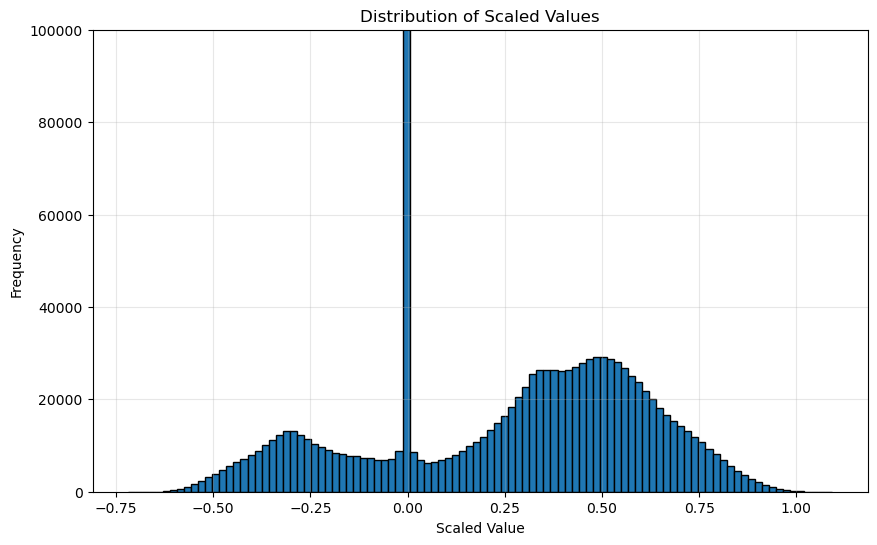

Min value: -0.7196556329727173
Max value: 1.0923917293548584
Mean value: 0.10749845951795578
Median value: 0.0


In [28]:
input_test_data_combined = data["input_test_data_combined"]
plot_value_distribution(input_test_data_combined)

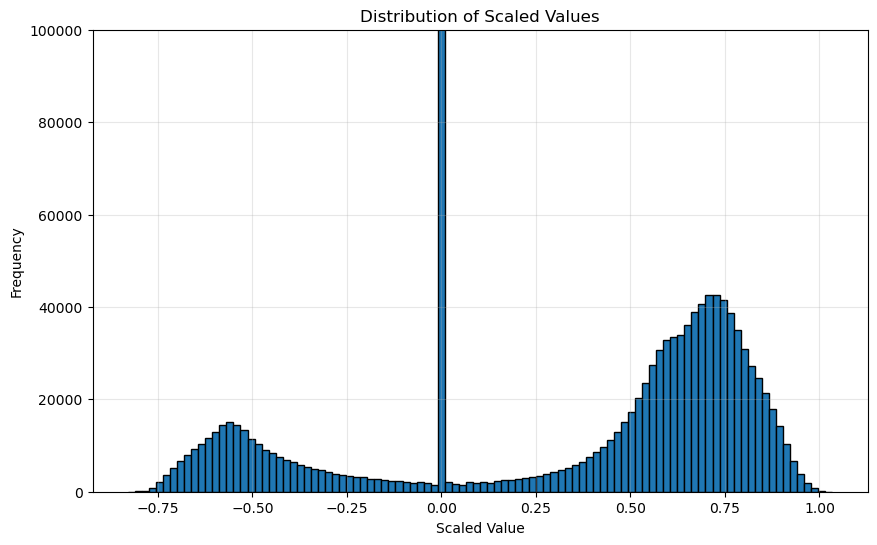

Min value: -0.82998126745224
Max value: 1.0339785814285278
Mean value: 0.14507661759853363
Median value: 0.0


In [19]:

# Usage
input_test_data_combined = data["input_test_data_combined"]
plot_value_distribution(input_test_data_combined)

In [109]:
np.set_printoptions(precision=2, suppress=True, floatmode='fixed')
print(np.round(data["input_train_data_combined"][2][:52].reshape(4*13), 2))

[-1.00 -1.00 -1.00 -1.00 -0.50 -0.50  0.50 -1.00 -1.00 -1.00 -1.00 -1.00
 -1.00 -1.00 -1.00 -1.00 -0.50 -0.50  0.50  0.00 -1.00 -1.00 -1.00 -1.00
 -1.00 -1.00 -1.00 -1.00 -1.00 -0.50 -0.50  0.50  0.00 -1.00 -1.00 -1.00
 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -0.50  0.50  0.50  0.00 -1.00 -1.00
 -1.00 -1.00 -1.00 -1.00]


In [65]:
model, train_metrics = train_model(data, HYPERPARAMETERS)

(None, 4, 13, 1)
(None, 52)
(None, 42)
(None, 52)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_profile_input (InputLaye  [(None, 4, 13, 1)]        0         
 r)                                                              
                                                                 
 flatten_input (Flatten)     (None, 52)                0         
                                                                 
 dense1 (QDense)             (None, 42)                2226      
                                                                 
 q_activation_4 (QActivatio  (None, 42)                0         
 n)                                                              
                                                                 
 batch_normalization_4 (Bat  (None, 42)                168       
 chNormalization)                                                
        

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 105), dtype=tf.float32, name='y_timed_input'), name='y_timed_input', description="created by layer 'y_timed_input'")


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 105), dtype=tf.float32, name='y_timed_input'), name='y_timed_input', description="created by layer 'y_timed_input'")


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 y_timed_input (InputLayer)  multiple                     0         ['y_timed_input[0][0]']       
                                                                                                  
 dense1 (QDense)             (None, 32)                   3392      ['y_timed_input[8][0]']       
                                                                                                  
 q_activation_3 (QActivatio  (None, 32)                   0         ['dense1[11][0]']             
 n)                                                                                               
                                                                                                  
 dense2 (QDense)             (None, 16)                   528       ['q_activation_3[11][0]

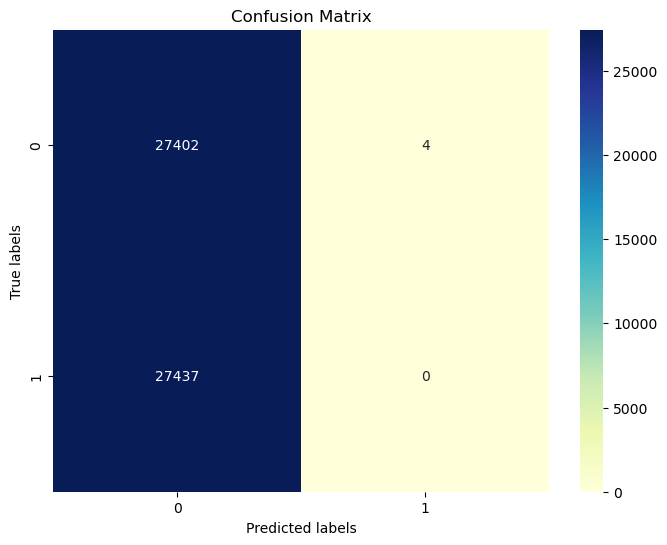

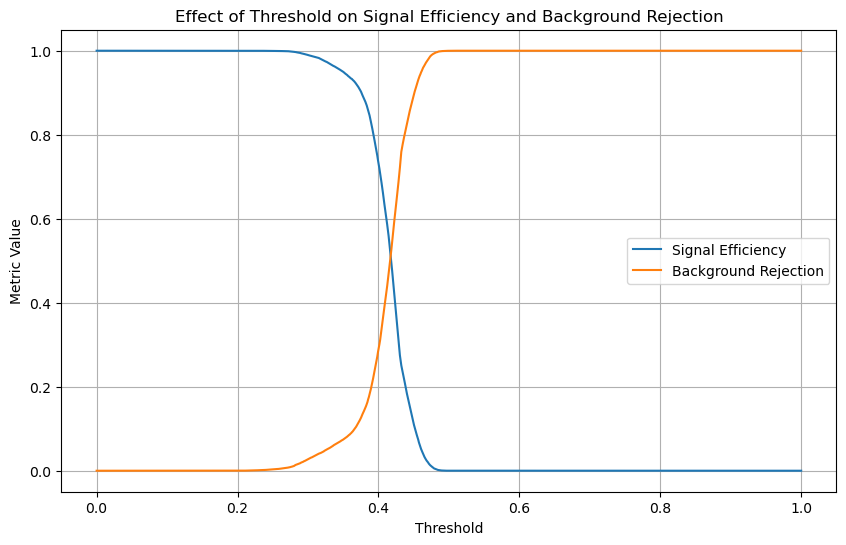

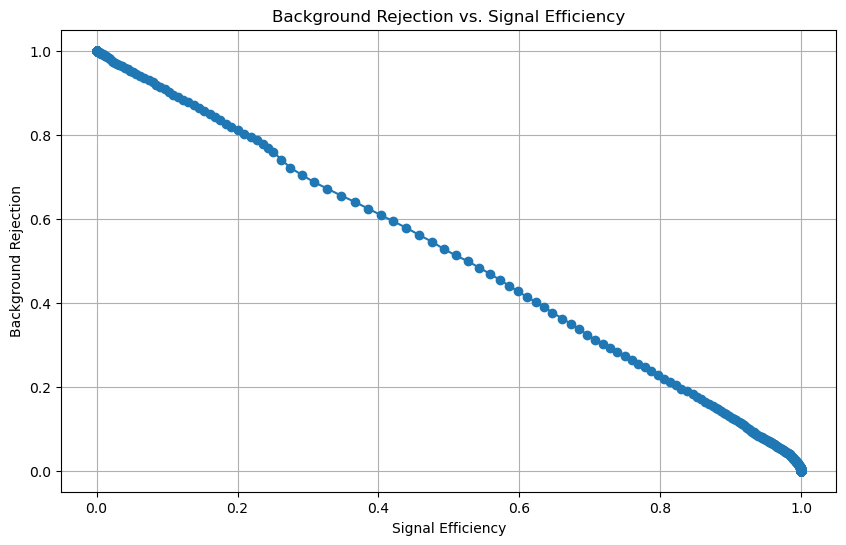

[(0.8741480482560047, 0.15387141501860907), (0.9020301053322156, 0.12657812157921622), (0.9292561140066333, 0.0955995037583011), (0.9600539417574808, 0.06480332773845143), (0.9799176294784415, 0.042508939648252204), (0.990122826839669, 0.026745968036196454), (0.9948609541859533, 0.01751441290228417), (0.9989794802638773, 0.006932788440487485)]


In [49]:
def fold_batch_norm(dense_layer, bn_layer):
    W, b = dense_layer.get_weights()
    gamma, beta, moving_mean, moving_var = bn_layer.get_weights()
    epsilon = bn_layer.epsilon
    std = np.sqrt(moving_var + epsilon)
    new_W = gamma / std * W
    new_b = gamma / std * (b - moving_mean) + beta
    return new_W, new_b

def create_folded_model(original_model): # Fold batch normalization layers into dense layers
    inputs = original_model.input
    x = inputs
    new_layers = []
    for layer in original_model.layers:
        if isinstance(layer, QDense):
            prev_layer = new_layers[-1] if new_layers else inputs
            if isinstance(prev_layer, BatchNormalization):
                # Fold the BatchNormalization into the previous Dense layer
                new_W, new_b = fold_batch_norm(layer, prev_layer)
                x = QDense(
                    layer.units, 
                    activation=layer.activation, 
                    weights=[new_W, new_b], 
                    kernel_quantizer=layer.kernel_quantizer, 
                    bias_quantizer=layer.bias_quantizer
                )(x)
                new_layers.pop()  # Remove the BatchNormalization layer
            else:
                x = layer(x)
        elif not isinstance(layer, BatchNormalization):
            x = layer(x)
        new_layers.append(x)

    outputs = x

    new_model = Model(inputs, outputs)
    return new_model

# Create the folded model
new_model = create_folded_model(loaded_model)

# Verify the new model
new_model.summary()


In [70]:
new_model.save(f'./{HYPERPARAMETERS["MODEL_TYPE"]}_best_performance.h5')

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

# results = hyperparameter_search(data, HYPERPARAMETERS, param_grid, result_file=SAVE_FILE)

try:
    results = hyperparameter_search(data, HYPERPARAMETERS, param_grid, result_file=SAVE_FILE)
    send_email_notification("All done with hyperparameter search", 'Done!')
except Exception as e:
    print("Error encountered:", e)
    send_email_notification("Hyperparameter search ran into an error", 'Go fix it')
######################################################################################################
##################################         TESTING          ##########################################
######################################################################################################

Testing hyperparameters: {'MODEL_TYPE': 'DNN', 'NUM_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'INPUT_SCALING': 'Quantized', 'DNN_LAYERS': [72], 'CONV_LAYER_DEPTHS': [4, 7], 'CONV_LAYER_KERNELS': [(3, 3), (3, 3)], 'FLATTENED_LAYERS': [7], 'CONV_LAYER_STRIDES': (1, 1), 'MAX_POOLING_SIZE': (2, 2), 'AU_ENCODER_LAYERS': [24], 'AU_DECODER_LAYERS': [52], 'WEIGHTS_BITS': 10, 'BIAS_BITS': 10, 'ACTIVATION_BITS': 15, 'INTEGER_BITS': 2, 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 150, 'PATIENCE': 20, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 10, 'FINAL_SPARSITY': 0.15, 'POST_PRUNE_EPOCHS': 50}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 53)]              0         
                                                                 
 dense1 (QDense)             (None, 72)                3888      
                              

In [2]:
def format_metrics(metrics):
    # Convert metrics list of tuples to a formatted string
    return ", ".join([f"({m1:.4f}, {m2:.4f})" for m1, m2 in metrics])

def reformat_hyperparameter_results(input_file, output_file):
    # Read the original JSON file
    with open(input_file, 'r') as f:
        data = json.load(f)

    # Process and format the metrics
    for key, value in data.items():
        if "metrics" in value:
            value["metrics"] = format_metrics(value["metrics"])

    # Write the updated data to the new JSON file
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

# Define input and output file names
input_file = 'OLD_CNN_hyperparameter_results.json'
output_file = 'CNN_hyperparameter_results.json'

# Call the function to reformat the JSON data
reformat_hyperparameter_results(input_file, output_file)

In [34]:
# Load in a saved model from the h5 file
co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
loaded_model = load_model('./DNN_L3_S32_best_performance.h5', custom_objects=co)
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 32)                3392      
                                                                 
 q_activation_3 (QActivatio  (None, 32)                0         
 n)                                                              
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense2 (QDense)             (None, 16)                528       
                                                                 
 q_activation_4 (QActivatio  (None, 16)                0   

1714/1714 [==============================] - 3s 2ms/step


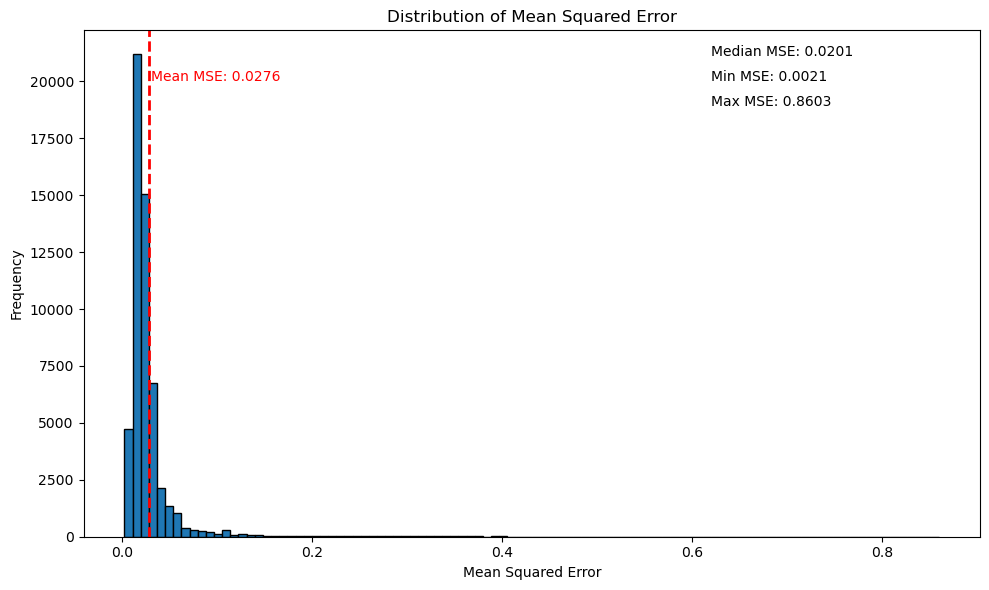

In [140]:
displayPerformance(data, model, HYPERPARAMETERS)

In [121]:
# Display model testing
def display_model_example(model, hyperparams, input_dataset_combined, target_dataset_coded, i):
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]

    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    target_datapoint = target_dataset_coded[i]

    if (MODEL_TYPE != "AE"):
        raise ValueError(f"model {MODEL_TYPE} type not supported yet")
    if input_datapoint.shape != (NUM_TIME_SLICES, 13):
        raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point 3")
        
    # Extracting the label from the target datapoint
    if target_datapoint[0] == 1:
        label = f"High p_t (over {TEST_PT_THRESHOLD} GeV)"
    elif target_datapoint[1] == 1:
        label = f"low p_t and negative charge"
    elif target_datapoint[2] == 1:
        label = f"low p_t and positive charge"
    else: 
        raise ValueError("Invalid labelling for the target data point")
    

    input_datapoint_reshaped = np.expand_dims(np.expand_dims(input_datapoint, axis=0), axis=-1)

    predictions = model.predict(input_datapoint_reshaped)

    # print("Formatted input looks like:")
    # for j in range(input_datapoint_reshaped.shape[1]):
    #     for k in range(input_datapoint_reshaped.shape[2]):
    #         print(input_datapoint_reshaped[0, j, k, 0], end=", ")
    #     print()
    # print("Formatted output looks like:")
    # for j in range(predictions.shape[1]):
    #     for k in range(predictions.shape[2]):
    #         print(predictions[0, j, k, 0], end=", ")
    #     print()

    # Reshape predictions to match input shape (4, 13)
    predictions_reshaped = predictions[0, :, :, 0]

    # Create the heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.1})
    fig.suptitle(f"Data Point: {i} | label: {label}", fontsize=16, y=1.05)

    # Function to create heatmap
    def create_heatmap(ax, data, title):
        max_val = np.max(np.abs(data))
        im = ax.imshow(data.T, cmap='plasma', vmin=-1.0, vmax=1.0-(1/(2**4)))
        ax.invert_yaxis()
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_yticks(np.arange(data.shape[1]))
        ax.grid(True, color='gray', alpha=0.7)
        ax.set_xlabel("Time Slice")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        return im

    # Create input heatmap
    im1 = create_heatmap(ax1, input_datapoint, "Input Data")

    # Create output heatmap
    im2 = create_heatmap(ax2, predictions_reshaped, "Output Data")

    # Add colorbars
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 30ms/step


/lscratch/alexyue/tmp/ipykernel_3599889/152443682.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


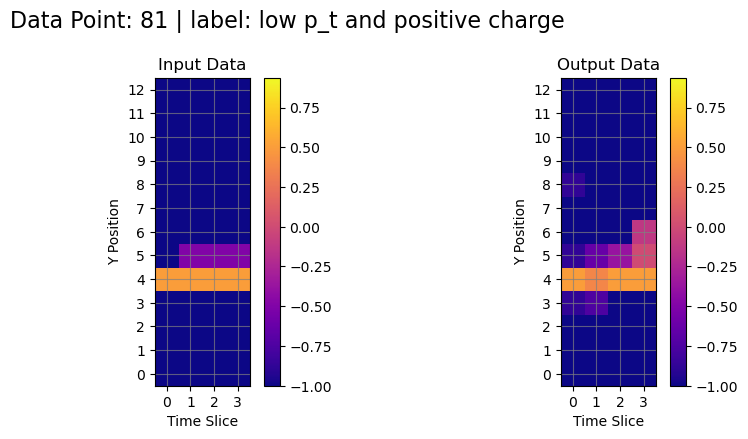

In [123]:
# MODEL TESTING DISPLAY
rand_idx = random.randint(0, 99)
input_data_combined_example = data["input_data_combined_example"]
target_data_coded_example = data["target_data_coded_example"]
input_data_example = data["input_data_example"]
target_data_example = data["target_data_example"]
display_model_example(model, HYPERPARAMETERS, input_data_combined_example, target_data_coded_example, rand_idx)